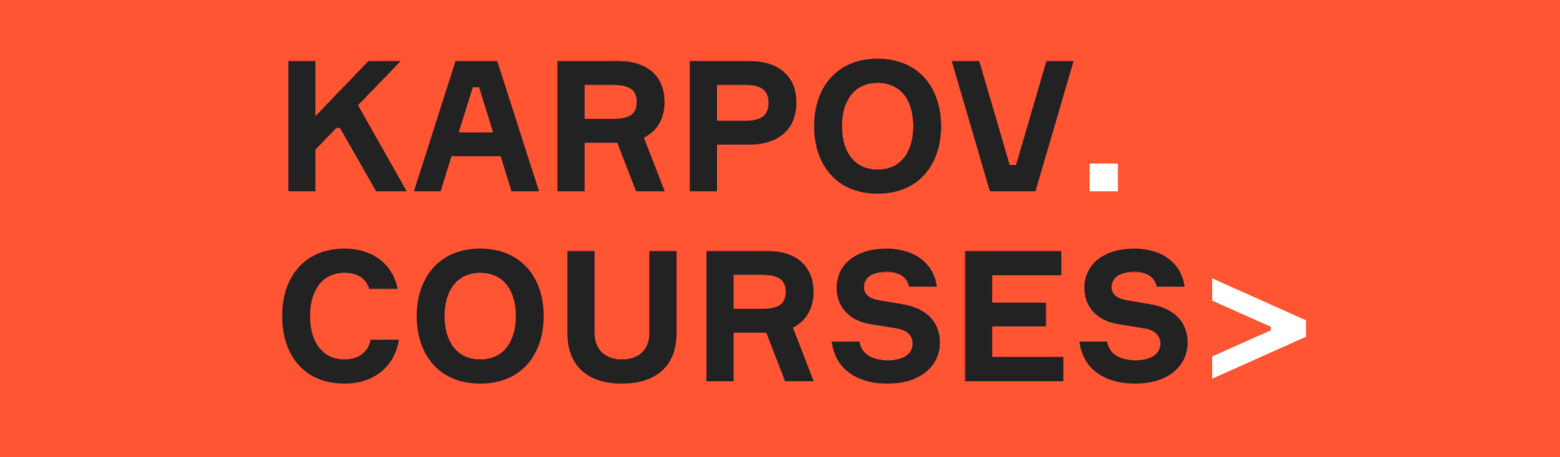

# Final Project 

## Задание 1. A/B–тестирование

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

Предлагаем Вам ответить на следующие вопросы:

 - На какие метрики Вы смотрите в ходе анализа и почему?
 - Имеются ли различия в показателях и с чем они могут быть связаны?
 - Являются ли эти различия статистически значимыми?
 - Стоит ли запускать новую механику на всех пользователей?


## В качестве входных данных Вы имеете 4 csv-файла:

 - groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
 - groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
 - active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
 - checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

____

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_ind, levene, normaltest, mannwhitneyu, norm
from tqdm.auto import tqdm
import pandahouse as ph

sns.set(
    font_scale=1.5,
    style="whitegrid",
    rc={'figure.figsize':(16,8)}
        )

#### Загрузка и первичный анализ данных:

In [2]:
groups = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-kuchiev/F/Проект_2_groups.csv', sep=';')
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [3]:
print(f'Кол-во строк: {groups.shape[0]}')
print(f'Кол-во дубликатов: {groups.duplicated().sum()}')
print(f'Кол-во уникальных id: {groups.id.nunique()}')

Кол-во строк: 74484
Кол-во дубликатов: 0
Кол-во уникальных id: 74484


In [4]:
groups.isna().sum() # проверка на пропущенные значения 

id     0
grp    0
dtype: int64

In [5]:
groups_add = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-kuchiev/F/Проект_2_group_add.csv', sep=',')
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [6]:
print(f'Кол-во строк: {groups_add.shape[0]}')
print(f'Кол-во дубликатов: {groups_add.duplicated().sum()}')
print(f'Кол-во уникальных id: {groups_add.id.nunique()}')

Кол-во строк: 92
Кол-во дубликатов: 0
Кол-во уникальных id: 92


Объединим данные в один фрейм:

In [7]:
groups_total = pd.concat([groups,groups_add], sort=False,ignore_index=True)
groups_total

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74571,200247820,B
74572,201032527,B
74573,201067612,B
74574,201067653,B


In [8]:
groups_total.duplicated().sum() # прверяем что не появилось дублей 

0

In [9]:
# поменяем назваие стольбца для удобства дальнейшего объединения таблиц
groups_total.rename(columns={'id':'student_id'}, inplace=True)  
groups_total.head()

,student_id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


Посмотрим на распределение пользователей по группам:

In [10]:
groups_total.grp.value_counts()

B    59883
A    14693
Name: grp, dtype: int64

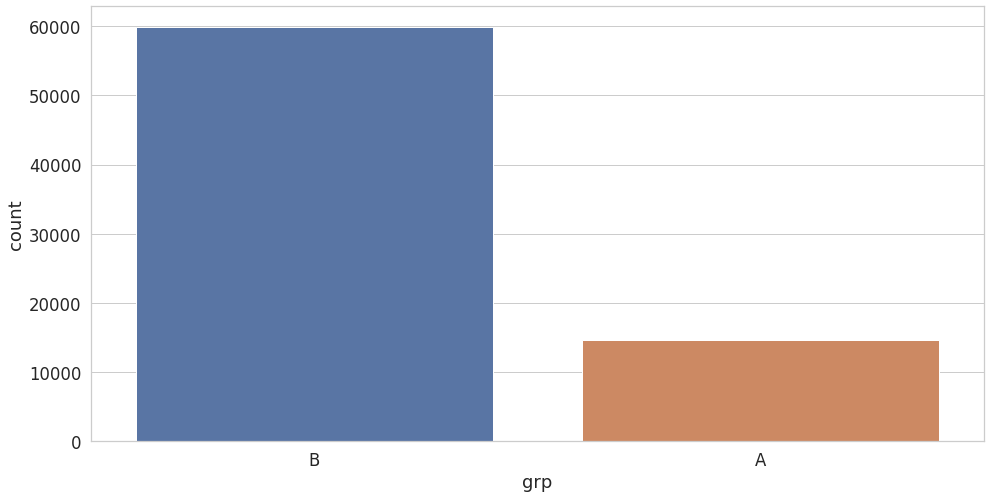

In [11]:
sns.countplot(data=groups_total, x='grp');

Распределение оказалось крайне не равномерным, что само по себе не является чем-то неправильным или критичным для A/B теста.
Дело в том, что обычно тестовая группа бывает меньше, в виду того, что катить новую фичу на большое кол-во пользователей рисковано и дорого, а в наших данных тестовая группа более чем в 3 раза больше.

____

In [12]:
# пользователи зашедшие на платфому в дни проведения эксперимента
active_studs = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-kuchiev/F/Проект_2_active_studs.csv')
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [13]:
print(f'Кол-во дубликатов:{active_studs.duplicated().sum()}')

Кол-во дубликатов:0


In [14]:
print(f'Кол-во пользователей зашедших на платформу во время эксперимента:{active_studs.shape[0]}')

Кол-во пользователей зашедших на платформу во время эксперимента:8341


Кажется логичным добавить колонку, которая будет как-то выделять пользователей которые заходили на платформу/сайт во время эксперимента, при дальнейшем объединении таблиц.Так и поступим. И судя по колнке student_id мы имеем дело с образовательной платформой.

In [15]:
active_studs['active'] = 1
active_studs.head()

,student_id,active
0,581585,1
1,5723133,1
2,3276743,1
3,4238589,1
4,4475369,1


In [16]:
# данные об оплатах в дни проведеня эксперимента
checks = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-kuchiev/F/Проект_2_checks.csv',sep=';')
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [17]:
checks.isna().sum() # проверка на пропущенные значения

student_id    0
rev           0
dtype: int64

In [18]:
print(f'Кол-во строк: {checks.shape[0]}')
print(f'Кол-во дубликатов: {checks.duplicated().sum()}')
print(f'Кол-во уникальных id: {checks.student_id.nunique()}')

Кол-во строк: 541
Кол-во дубликатов: 0
Кол-во уникальных id: 541


In [19]:
checks.rev.describe()# посмортим немного описательной статистки по платежам 

count     541.000000
mean     1059.752317
std       762.712359
min       199.000000
25%       290.000000
50%       840.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

- Максимальный платеж - 4650
- Минимальный платеж - 199
- Медианный - 840 

In [20]:
checks.rev.value_counts().head(10) # распределение по платежам  

1900.0000    97
290.0000     94
690.0000     78
199.0000     46
990.0000     41
1900.0001    36
840.0000     27
1140.0000    25
580.0000     15
590.0000     11
Name: rev, dtype: int64

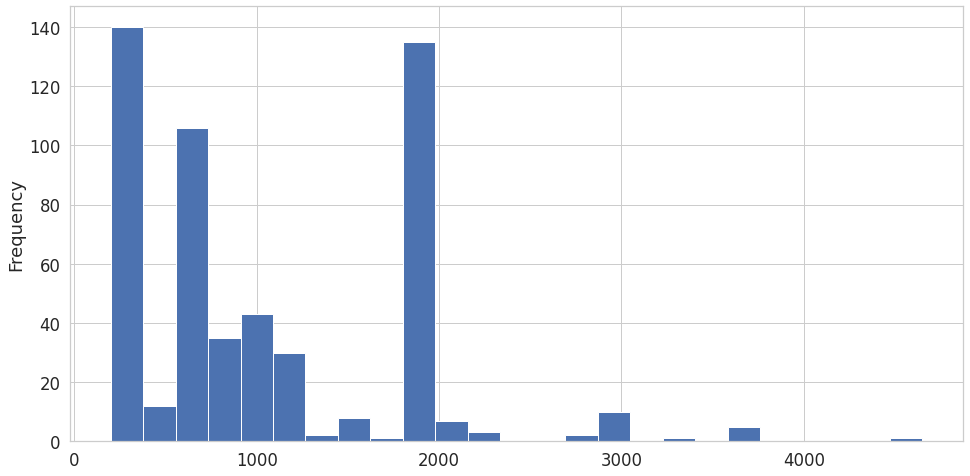

In [21]:
checks.rev.plot(kind='hist', bins=25);

Распределение платежей не равномерное, имеется 3 моды(платежи по 1900, 290, 690).
Но это без привязки к группам, а нас интересуют различия как раз между группми.

____

Предварительно можно сделать следующие выводы:
 - данные очень "чистые", без пропусков и нужного типа
 - таблица с активными пользователми насчитывает 8341 записи, тогда как общая таблица 74576 записи.
   Исходя из условия задания, если пользователь не заходил на платформу/сайт во время эксперимента, то и увидеть/ощутить 
   изменения механики оплат на себе он не мог. Из этого следует, что анализировать и сранивать нужно только активных     пользователей.

Соединим наши таблицы в одну.
Кажется логичным соединять таблицу активных пользователей с общей с помощью inner джойна, чтобы остались толкько те, кто нам нужен, но сделаем все обьединения через left чтобы пока что не потерять пользоватлей и покрутить данные еще, отфильтровать нужное всегда успеем.

In [22]:
# делаем мердж и заполняем пропуски 0, так у нас 0 помечены те, кто не заходил во время эксперимента
final_df = groups_total.merge(active_studs, how='left', on = 'student_id').fillna(0)
final_df.head()

,student_id,grp,active
0,1489,B,0.0
1,1627,A,1.0
2,1768,B,0.0
3,1783,B,0.0
4,1794,A,0.0


____

Теперь присоединим таблицу с оплатами, но перед этим тоже создадим столбец для того чтобы выделить в общем фрейме тех, кто платил.

In [23]:
checks['has_rev'] = 1
checks.head()

,student_id,rev,has_rev
0,1627,990.0,1
1,3185,690.0,1
2,25973,690.0,1
3,26280,690.0,1
4,100300,990.0,1


In [24]:
final_df = final_df.merge(checks, how='left', on='student_id').fillna(0)
final_df.head()

,student_id,grp,active,rev,has_rev
0,1489,B,0.0,0.0,0.0
1,1627,A,1.0,990.0,1.0
2,1768,B,0.0,0.0,0.0
3,1783,B,0.0,0.0,0.0
4,1794,A,0.0,0.0,0.0


Покрутим/проанализируем получившийся датафрейм

In [25]:
print(f'Число активных пользователей: {final_df.query("active == 1").shape[0]}')
print(f'Число активных и сделавших покупку пользователей: {final_df.query("active == 1 & has_rev == 1").shape[0]}')
print(f'Число активных и не сделавших покупку пользователей: {final_df.query("active == 1 & has_rev == 0").shape[0]}')
print(f'Число неактивных и сделавших покупку пользователей: {final_df.query("active == 0 & has_rev == 1").shape[0]}')
print(f'Число неактивных и не сделавших покупку пользователей: {final_df.query("active == 0 & has_rev == 0").shape[0]}')

Число активных пользователей: 8341
Число активных и сделавших покупку пользователей: 392
Число активных и не сделавших покупку пользователей: 7949
Число неактивных и сделавших покупку пользователей: 149
Число неактивных и не сделавших покупку пользователей: 66086


____

Стоить прокомментировать 149 пользователей заплативших не заходя на сайт/платформу:
 - можно проедположить что имеют место автоплатежи
 - ошибка системы сплитования 
 - ошибки в логфайлах 

Утверждать с уверенностью, не имея дополнительных данных о том, как долго продолжался А/В тест,данные о времени захода пользователя и.т.д, мы не можем.
Следуя условию задачи, далее будем продаолжать анализ только с теми пользователми на которых проводился тест.

In [26]:
exp_data = final_df.query("active == 1")
exp_data.head()

,student_id,grp,active,rev,has_rev
1,1627,A,1.0,990.0,1.0
10,2085,B,1.0,0.0,0.0
12,2215,B,1.0,0.0,0.0
43,3391,A,1.0,0.0,0.0
45,3401,B,1.0,0.0,0.0


In [27]:
exp_data.grp.value_counts()

B    6803
A    1538
Name: grp, dtype: int64

Cреди активных пользователей так же наблюдаем дисбаланс по группам.

Посмотрим на распределение платежей:

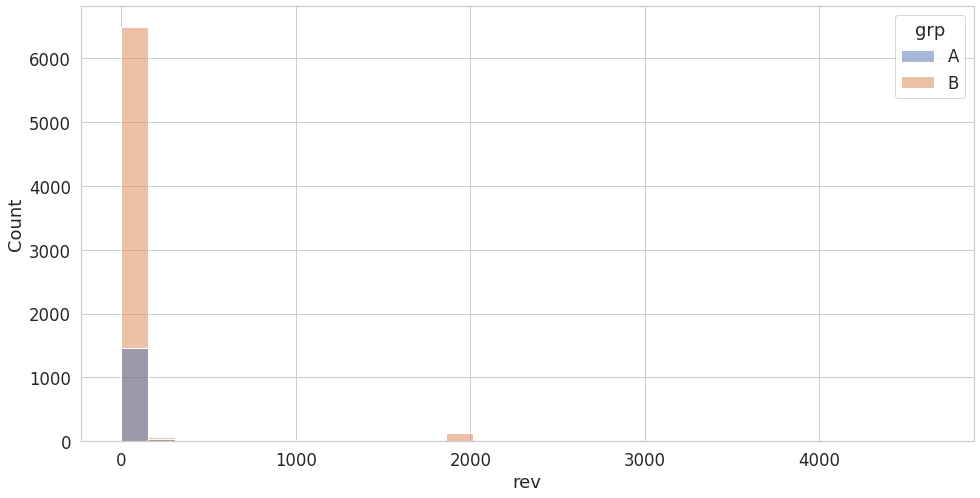

In [28]:
sns.histplot(data = exp_data, x = 'rev', hue = 'grp', bins= 30);

График оказался не очень информативным в силу того, что подавляющее большинство пользователей заходивших во время эксперимента не сделало покупку.

Построим распредление трат только тех пользователей чей revenue > 0:

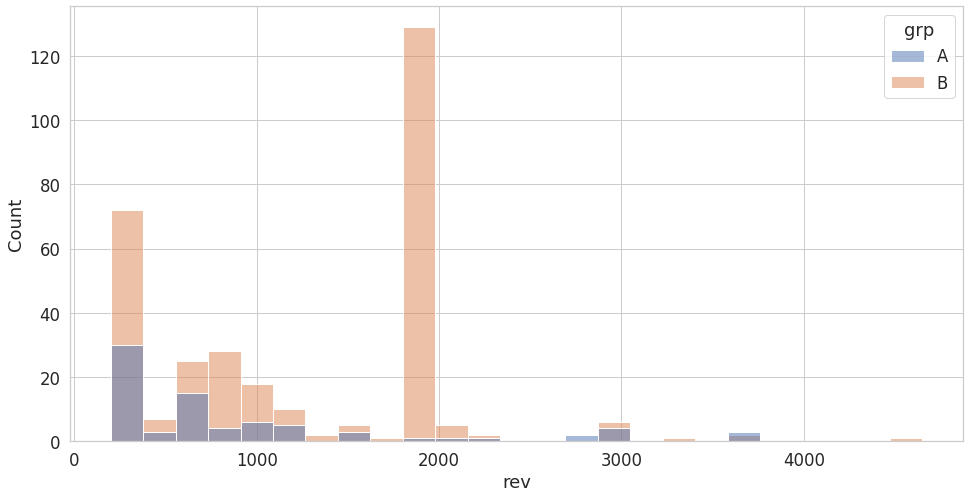

In [29]:
sns.histplot(data = exp_data.query('rev > 0'), x = 'rev', hue = 'grp', bins= 25);

Глядя на график можно заметить, что наши распределения отличаются только пиком в группе В в районе rev = ~1900.

Проверим цифрами:

In [30]:
exp_data.query("rev > 0")\
        .groupby(['grp','rev'],as_index=False)\
        .agg({'student_id':'count'})\
        .rename(columns={'student_id':'num_checks'})\
        .pivot(columns='grp', values='num_checks', index='rev')\
        .sort_values(by='B', ascending=False)\
        .fillna(0)\
        .head(10)

grp,A,B
rev,,
1900.0000,0.0,93.0
290.0000,25.0,45.0
1900.0001,0.0,35.0
199.0000,5.0,27.0
840.0000,3.0,21.0
990.0000,5.0,17.0
690.0000,4.0,13.0
1140.0000,2.0,9.0
398.0000,1.0,6.0


В группе В 128 пользователей совершили платеж на 1900, тогда как в группе А таких не оказалось вовсе.

_____

#### Так как мы тестировали влияние новой механики оплаты, и исходя из имеющихся данных, нашими метриками будут:
 - конверсия(CR) 
 - средний доход с пользователя (ARPU)  
 - средний доход с платящего пользователя (ARPPU).

In [31]:
grpA = exp_data.loc[exp_data.grp=='A']
grpA

,student_id,grp,active,rev,has_rev
1,1627,A,1.0,990.0,1.0
43,3391,A,1.0,0.0,0.0
331,109623,A,1.0,0.0,0.0
614,133678,A,1.0,0.0,0.0
1002,175944,A,1.0,0.0,0.0
...,...,...,...,...,...
74416,5668989,A,1.0,0.0,0.0
74469,5690284,A,1.0,0.0,0.0
74523,5723133,A,1.0,0.0,0.0
74528,5729371,A,1.0,0.0,0.0


In [32]:
grpB = exp_data.loc[exp_data.grp=='B']
grpB

,student_id,grp,active,rev,has_rev
10,2085,B,1.0,0.0,0.0
12,2215,B,1.0,0.0,0.0
45,3401,B,1.0,0.0,0.0
112,22994,B,1.0,0.0,0.0
159,26899,B,1.0,0.0,0.0
...,...,...,...,...,...
74539,5740903,B,1.0,1900.0,1.0
74543,5760471,B,1.0,0.0,0.0
74545,5777081,B,1.0,0.0,0.0
74561,5945085,B,1.0,0.0,0.0


#### Conversion Rate

In [33]:
cr = exp_data.groupby('grp', as_index=False)\
             .agg({'has_rev':'mean'})
cr

,grp,has_rev
0,A,0.050715
1,B,0.046156


В тестовой группе конверсия уменьшилась. Необходимо удостовериться в том, является ли это различие стат. значимо.
Для этого используем критерий согласия Пирсона или иначе хи квадрат.

Сформулируем гипотезы:
 
 H0 - конверсии в двух группах не отличаются
 
 H1 - конверсии в двух группах отличаются

In [34]:
stat, p, dof, expected  = chi2_contingency(pd.crosstab(exp_data.grp, exp_data.has_rev))

print(p)
if p > 0.05:
    print('Оснований для отклонения нулевой гипотезы у нас нет.')
elif p < 0.05:
    print('Отклоняем нулевую гипотезу.')
else:
    print('Необходимо перестмотерть p-value')

0.48625240457231045
Оснований для отклонения нулевой гипотезы у нас нет.


____

#### ARPU - Avarage Revenue Per User

In [35]:
np.mean(grpA.rev), np.mean(grpB.rev)

(47.34720416124838, 58.058798103777754)

In [36]:
len(grpB.rev), len(grpA.rev) # размер выборок

(6803, 1538)

Cредний доход с пользователя в двух группах отличается.
Необходимо подтвердить или отвергнуть это с помощью стат. тестов.

Н0 - средний доход с пользователя в двух группах не отличается

Н1 - средний доход с пользователя в двух группах отличается

В нашем распоряжении критерий Стьюдента, его непараметрический аналог - критерий Манна-Уитни и бустрап.

Критерий Стьюдента имеет ряд необходимых допущений: случайность выборки, ее репрезентативность, и нормалььное распределение, а так же гомогенность дисперсий. Последние два являются не строгими. При не нермальном распределении необходимо чтобы выборки были достаточно большими, а при различии в дисперсиях можно воспользоваться поправкой Уэлча при использовании t-критерия.
Так же можно прологорифмировать наши выбрки, но данная операция может навредить при принятии решений бизнесса, так как отличия в логорифмированных данных не то же самое что при сравнении обычный средних.И в наших данных при подсчете ARPU это невозможно так как есть большое количество записей с 0 оплатой, а как известно логорифм от 0 это бесконечность).


Критерий Манна-Уитни хорош когда распределение признака не нормально, но он плохо интерпритируем и так же чувсителен при наличии в данных большого кол-ва повторяющихся знаяений, а это как раз наш случай. 

Бустрап же менее чувствителен ко всем вышеизложенным требованиям но является 'тяжелым'.

Я буду использовать кртерий стьюдента и бутсрап.

Из графиков выше было очевидно, что распределение не нормальное, но следует подтвердить это:

In [37]:
print(normaltest(grpA.rev))
print(normaltest(grpB.rev))

NormaltestResult(statistic=2240.595797407402, pvalue=0.0)
NormaltestResult(statistic=7797.399211581946, pvalue=0.0)


С помощью теста Левена, проверим различаются ли дисперсии:

In [38]:
levene(grpB.rev,grpA.rev)

LeveneResult(statistic=1.501460829433639, pvalue=0.22048133327049665)

p-value равный 0.22 не дает нам оснований отклонить гипотезу о равенстве дисперсий.

In [39]:
ttest_ind(grpA.rev, grpB.rev)

Ttest_indResult(statistic=-1.2253411073793445, pvalue=0.22048133326988378)

t-test на наших данных показал p-value > 0.05 , что не дает нам оснований отклонить нулевую гипотезу.

In [40]:
mannwhitneyu(grpA.rev, grpB.rev)

MannwhitneyuResult(statistic=5252113.0, pvalue=0.5099747992861601)

Манн-Уитни так же показал уровень значимости выше 0.05.

Но давайте посмотрим что произойдет, если мы будем многократно извлекать средние, складывать их в массив, затем посторим распределение этих средних и применим стат тесты:

In [41]:
mean_rev_grpA_1000 = []
for i in range(1000):
    mean_rev_grpA_1000.append(
        np.mean(grpA.rev.sample(frac=1,replace=True))
    )

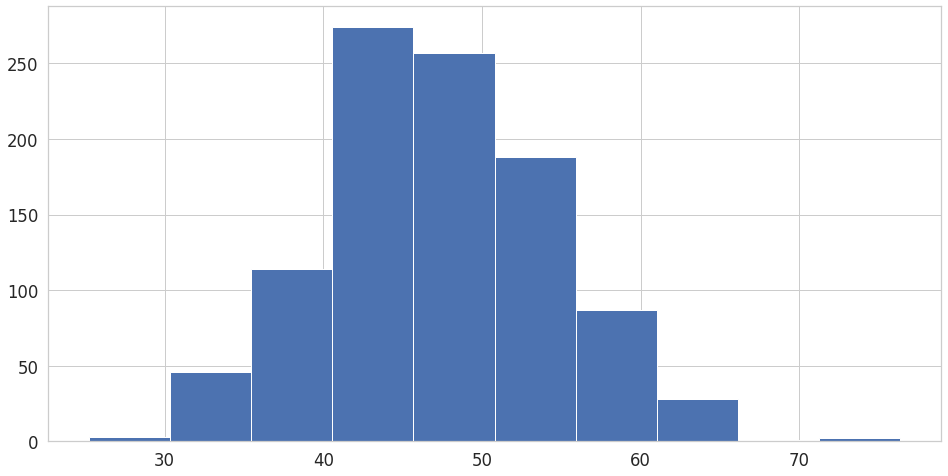

In [42]:
plt.hist(mean_rev_grpA_1000);

In [43]:
mean_rev_grpB_1000 = []
for i in range(1000):
    mean_rev_grpB_1000.append(
        np.mean(grpB.rev.sample(frac=1,replace=True))
    )

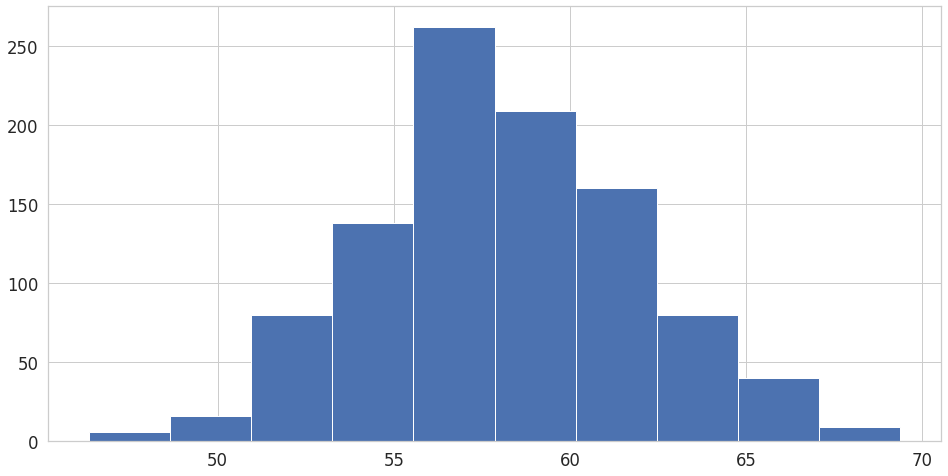

In [44]:
plt.hist(mean_rev_grpB_1000);

ЦПТ во всей красе!)

In [45]:
ttest_ind(mean_rev_grpA_1000,mean_rev_grpB_1000)

Ttest_indResult(statistic=-41.84831509776254, pvalue=2.1748378222603625e-275)

А вот средние из многократных выборок средних уже отличаются стат значимо!

Теперь напишем функцию бутсрапа, котрая будет извлекать из наших групп подвыборки, сравнивать разницу средних в этих выборках и класть эту разницу в массив и затем строить распределение разницы средних:

In [46]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {#"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

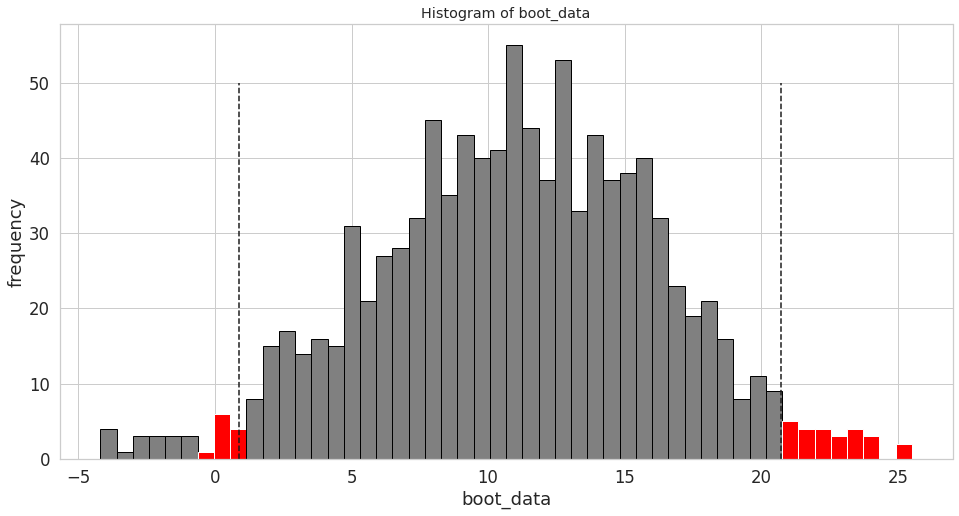

{'quants':                0
 0.025   0.884595
 0.975  20.705006,
 'p_value': 0.03293230484763812}

In [47]:
get_bootstrap(grpB.rev, grpA.rev)

Результат приминения бустрапа так же говорит нам о стат значимом различии среднего дохода с пользователя в двух группах.
На графике видно, что ноль не входит в доверительный интервал и p-value < 0.05. Хотя стоит отметить что p-value очень близка к 0.05. 

_____

#### ARPPU - Avarage Revenue Per Paying User

Теперь анализируем только платящих пользователей.

Данных еще меньше.
Гипотезы все те же:

Н0 - средний доход с платящего пользователя в группах не различается

Н1 - средний доход с платящего пользователя в группах  различается

Так как данных еще меньше, то выбор бустрапа будет еще более оправдан, но посмотрим на другие критерии тоже.

In [48]:
len(grpA.query('rev>0'))

78

In [49]:
len(grpB.query('rev>0'))

314

In [50]:
ttest_ind(grpA.query('rev>0').rev, grpB.query('rev>0').rev)

Ttest_indResult(statistic=-3.1337795050930985, pvalue=0.0018562025265765867)

t-test дает нам основания для отклонения нулевой гипотезы.

In [51]:
mannwhitneyu(grpA.query('rev>0').rev, grpB.query('rev>0').rev)

MannwhitneyuResult(statistic=9001.0, pvalue=0.0002511393831406922)

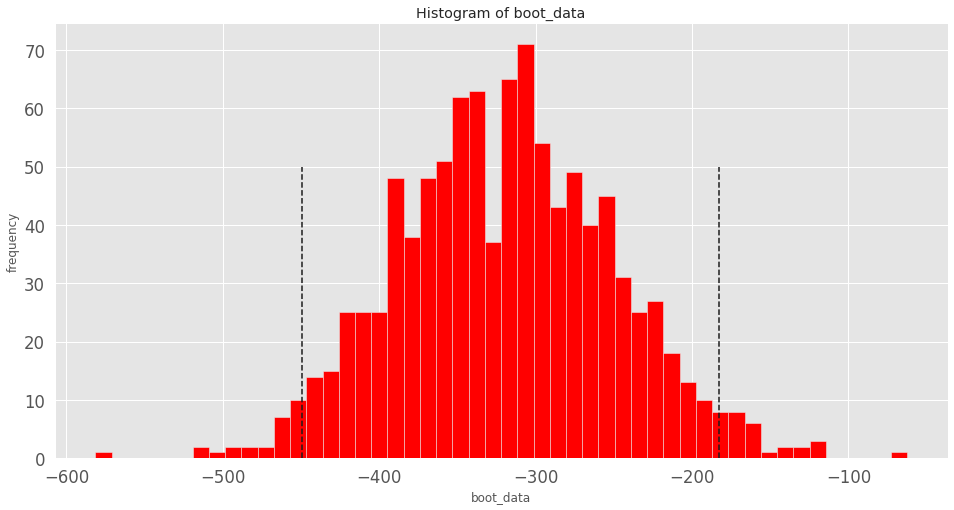

{'quants':                 0
 0.025 -449.420393
 0.975 -182.569835,
 'p_value': 3.8036560679774494e-06}

In [52]:
get_bootstrap(grpA.query('rev>0').rev, grpB.query('rev>0').rev)

Все три теста гвоврят нам о том что мы должны отклонить нулевую гипотезу.

### Выводы:

1. Конверсия в тестовой группе снизилась, но статистически это изменение оказалось не значимым.
   Однако сам факт этого негативен, так как мы оценивали влияние влияние новой механики оплаты и по идее она должны была делать    процесс покупки легче/удобнее и следовательно вести к увеличению конверсии.
2. Средний доход с пользователя вырос, однако стат тесты показали разные результаты:
   т-тест и манн-уитни показали что различия не значимы, тогда как бустрап показал значимые различия, но с р-value близким к пороговому значению принятия решения. Я думаю что дело в том, что в данных подавляющее большинство записей где сумма равна нулю. 
3. Средний доход с платящих пользователей так же вырос в тестовой группе и все тесты показали, что различия значимы.
4. Так же хочется отметить что по сути единственное отличие в распределениях оплат в двух группах заключается в том, что в тестовой группе имеется пик оплат на сумму в 1900. Тут надо подумать как изменения механики оплаты может вести к тому, что пользователи наснут тратить определенную сумму. Самый плохой вариант это если во время проведения эксперимента проводилась еще какая нибудь акция и при сплитовании пользователей получилось так, что пользователи в тестовой группе видели не только изменение в механике оплаты, но и акцию, в таком случае наш А/В тест полностью не валиден. 
5. Однако с другой стороны, так как у нас образовательная платформа, и если представить что раньше у нас поекпались все курсы по отдельности, а теперь появилась возможность обьединять курсы в специальсности и брать их вместе платя определенную сумму, и если это считать изменением механики оплаты, то результаты теста показыват что результат положительный.

Подводя итог скажу что катить новую механику оплаты(чтобы под этим не подразумевалось) на всех, я бы пока не стал.
Собрал бы еще данные, проверил правильно сплитуются пользователи на группы, продлил бы время проведения А/В теста и убедился что мы тестируем влияние какого то одного эффекта, а не новой мехаики и акций и прочего.



____

## Задание 2. SQL

Все данные находятся в табличном виде в Clickhouse.

#### 2.1 Очень усердные ученики.

2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

Подключаемся к базе данных:

In [53]:
connection = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

Посмотрим на данные хранящиеся в таблице:

In [54]:
q_1 = '''
    SELECT
        st_id,
        toDateTime(timest) as timest,
        correct, 
        subject
        
    FROM 
    default.peas
    LIMIT 10
    
    '''
query_1 = ph.read_clickhouse(query=q_1, connection=connection)
query_1

,st_id,timest,correct,subject
0,100379,2021-10-30 13:32:29,1,Theory of probability
1,100379,2021-10-30 14:11:19,0,Vizualization
2,100379,2021-10-30 15:54:22,1,Theory of probability
3,100379,2021-10-30 16:44:50,1,Vizualization
4,100379,2021-10-30 17:15:05,1,Theory of probability
5,100379,2021-10-30 18:02:37,1,Theory of probability
6,100379,2021-10-30 18:17:25,1,Vizualization
7,100379,2021-10-30 18:32:26,0,Theory of probability
8,100379,2021-10-30 19:19:33,1,Vizualization
9,100379,2021-10-30 19:28:03,1,Theory of probability


Cмотрим за какой период времени данные в тадлице:

In [55]:
q_2 = '''
    SELECT
        min(toDateTime(timest)) as first_date,
        max(toDateTime(timest)) as last_date
    FROM 
    default.peas
    
    '''
query_2 = ph.read_clickhouse(query=q_2, connection=connection)
query_2

,first_date,last_date
0,2021-10-30 13:00:00,2021-10-31 17:29:52


Считаем усердных учеников:

In [56]:
q_3 = '''
  SELECT
      COUNT(DISTINCT st_id) as good_students
  FROM (
           SELECT
                st_id,
                SUM(correct) as corr_tasks
            FROM 
                default.peas
            GROUP BY
                st_id
            HAVING
                corr_tasks >= 20
       ) 
    '''
query_3 = ph.read_clickhouse(query=q_3, connection=connection)
query_3

,good_students
0,136


Ну очевидно, что если в условии задачи под текущим месяцем подразумевается ноябрь 2022, то таких студентов в таблице не обнаружится.

____

#### 2.2 Оптимизация воронки

2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

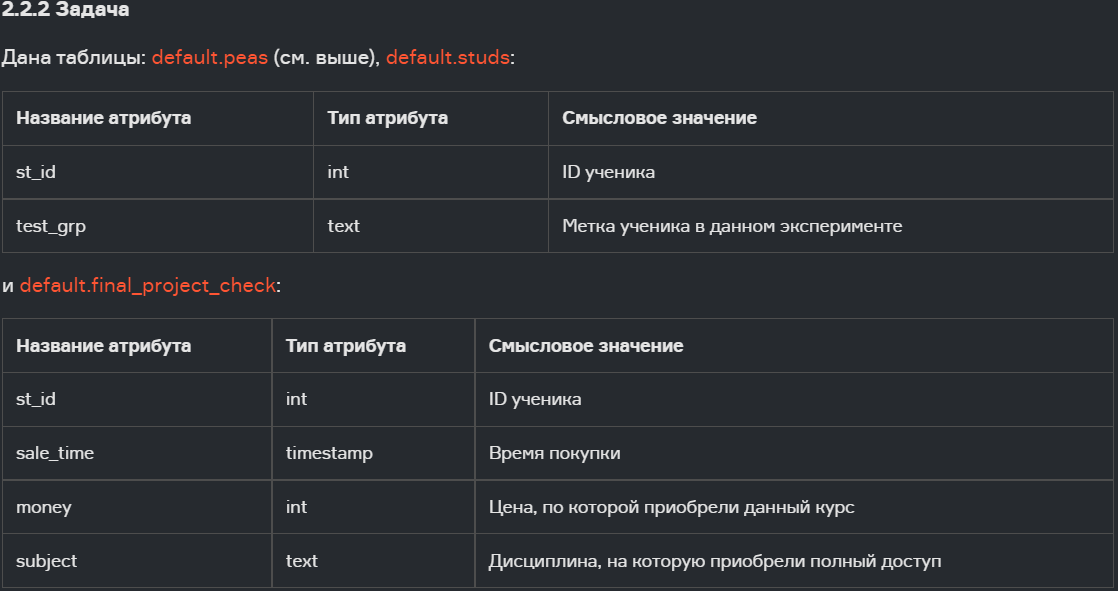


Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

 - ARPU 
 - ARPAU 
 - CR в покупку 
 - СR активного пользователя в покупку 
 - CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
 - ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [57]:
q_4 = '''

    SELECT 
        test_grp as grp,
        round(SUM(fcp.money)/uniqExact(s.st_id),2) as ARPU,
        round(SUMIf(fcp.money, query_in.act > 10)/uniqIf(s.st_id, query_in.act > 10),2) as ARPAU,
        round(uniqIf(s.st_id, fcp.money > 0)/uniqExact(s.st_id)*100, 2) as CR,
        round(uniqIf(s.st_id, query_in.act > 10 and fcp.money > 0)/uniqIf(s.st_id, query_in.act > 10)*100,2) as CR_active,
        round(uniqIf(s.st_id, query_in.math_active >= 2 and fcp.subject = 'Math' and fcp.money > 0)*100 /
              uniqIf(s.st_id, query_in.math_active >= 2), 2) as CR_math
    FROM 
        studs s
    LEFT JOIN final_project_check fcp
        ON s.st_id = fcp.st_id
    LEFT JOIN (
            SELECT 
                st_id, 
                SUM(correct) as act, 
                SUMIf(correct, subject = 'Math') as math_active
            FROM 
                peas
            GROUP BY 
                st_id) as query_in 
    ON s.st_id = query_in.st_id

    GROUP BY test_grp

'''
query_4 = ph.read_clickhouse(query=q_4, connection=connection)
query_4

,grp,ARPU,ARPAU,CR,CR_active,CR_math
0,control,4540.98,10393.70,4.92,11.02,6.12
1,pilot,11508.47,29739.58,10.85,26.04,9.52


____

## Задание 3. Python

#### 3.1 Задача

- Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

- Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [94]:
def get_data(df1: 'DataFrame', df2: 'DataFrame', df3: 'DataFrame', df4: 'DataFrame') -> 'DataFrame':
    '''
       Функция get_data принимает в качестве атрибутов 
       4 датафрейма соединяет их рассчитавет метрики
       и подает на выход датафрейм с метриками.
       
    '''
    df1.columns = df2.columns
    all_groups = pd.concat([df1, df2])
    all_groups.rename(columns={'id':'student_id'}, inplace=True)
    df3['active'] = 1
    df4['has_rev'] = 1
    final_df = all_groups.merge(df3, how='left', on='student_id').fillna(0)
    final_df = final_df.merge(df4, how='left', on='student_id').fillna(0)
    final_df = final_df.query('active == 1')
    metrics_df = final_df.groupby('grp', as_index=False)\
                         .agg({'student_id':'count','rev':['sum','mean'],'has_rev':['sum','mean'], })
                         
    metrics_df.columns = ['grp','active_users','revenue','ARPU','paying_users','CR']
    #metrics_df = metrics_df.assign(paying_users = final_df.query('rev > 0').groupby('grp').agg({'rev': 'count'})) 
    #metrics_df['ARPAU'] = (metrics_df.revenue / metrics_df.active_users)
    metrics_df['ARPPU'] = round(metrics_df.revenue / metrics_df.paying_users,2)
    metrics_df['ARPU'] = round(metrics_df['ARPU'],2)
    metrics_df['CR'] = round(metrics_df.CR*100,2)
    metrics_df['revenue'] = round(metrics_df.revenue,2)
    
    return metrics_df

In [100]:
metrics = get_data(groups,groups_add,active_studs,checks)
metrics

,grp,active_users,revenue,ARPU,paying_users,CR,ARPPU
0,A,1538,72820.0,47.35,78.0,5.07,933.59
1,B,6803,394974.0,58.06,314.0,4.62,1257.88


In [124]:
def show_metrics(metrics: 'DataFrame') -> 'graphs':
    '''
    Функция show_metrics принимает на вход один атрибут-датафрейм с метриками
    и возвращает графики данных метрик.
    
    '''
    
    plt.figure(figsize=(10, 6))
    splot=sns.barplot(x=metrics.grp,y="CR",data=metrics)
    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
    plt.figure(figsize=(10, 6))
    splot=sns.barplot(x=metrics.grp,y="ARPU",data=metrics)
    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

    plt.figure(figsize=(10, 6))
    splot=sns.barplot(x=metrics.grp,y="ARPPU",data=metrics)
    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    

    
    return plt.show()

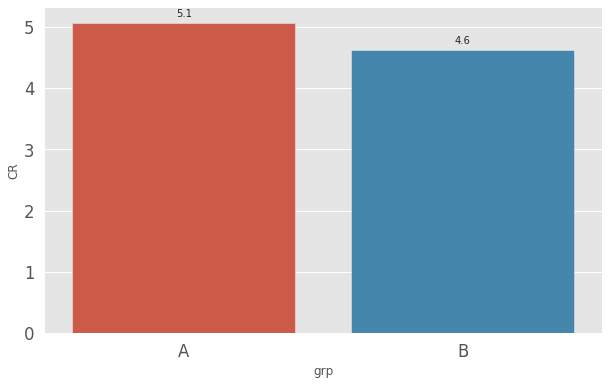

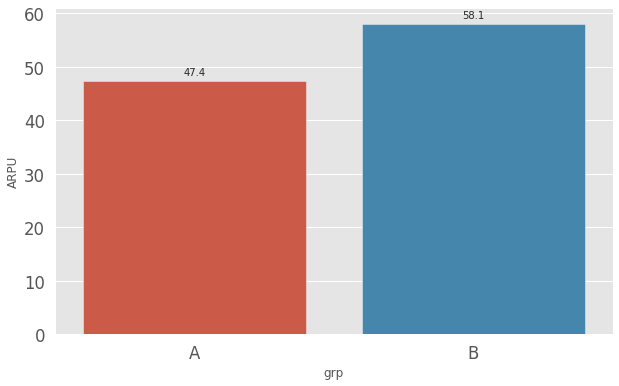

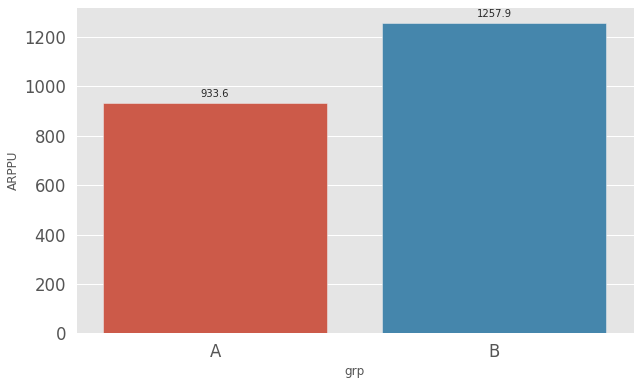

In [125]:
show_metrics(metrics)